# Cell node

In [18]:
from histocartography.preprocessing import NucleiExtractor, DeepFeatureExtractor, KNNGraphBuilder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
 
nuclei_detector = NucleiExtractor()
feature_extractor = DeepFeatureExtractor(architecture='resnet34', patch_size=72)
knn_graph_builder = KNNGraphBuilder(k=5, thresh=50, add_loc_feats=True)

File already downloaded.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'histocartography.ml.models.hovernet.HoverNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'histocartography.ml.models.hovernet.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class '

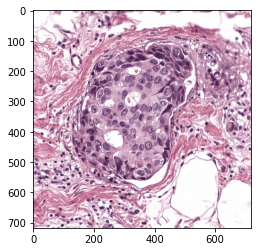

In [3]:
image = np.array(Image.open('283_dcis_4.png'))
plt.imshow(image)

In [4]:
nuclei_map, _ = nuclei_detector.process(image)

Patch-level nuclei detection: 100%|██████████| 13/13 [01:24<00:00,  6.47s/it]


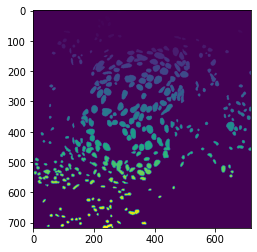

In [5]:
import matplotlib.pyplot as plt
plt.imshow(nuclei_map)

In [6]:
np.unique(nuclei_map)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [17]:
len(np.unique(nuclei_map))

332

In [7]:
features = feature_extractor.process(image, nuclei_map)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
features.shape

torch.Size([331, 512])

In [15]:
cell_graph = knn_graph_builder.process(nuclei_map, features)
cell_graph

DGLGraph(num_nodes=331, num_edges=1500,
         ndata_schemes={'centroid': Scheme(shape=(2,), dtype=torch.float32), 'feat': Scheme(shape=(514,), dtype=torch.float32)}
         edata_schemes={})

# Tissue node

In [35]:
import os
from glob import glob
import argparse
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch 
from dgl.data.utils import save_graphs
import h5py
import cv2

from histocartography.preprocessing import (
    VahadaneStainNormalizer,         # stain normalizer
    NucleiExtractor,                 # nuclei detector 
    DeepFeatureExtractor,            # feature extractor 
    KNNGraphBuilder,                 # kNN graph builder
    ColorMergedSuperpixelExtractor,  # tissue detector
    DeepFeatureExtractor,            # feature extractor
    RAGGraphBuilder,                 # build graph
    AssignmnentMatrixBuilder         # assignment matrix 
)

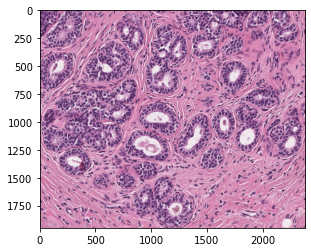

In [24]:
image=cv2.imread('target.png')
plt.imshow(image[:,:,::-1])

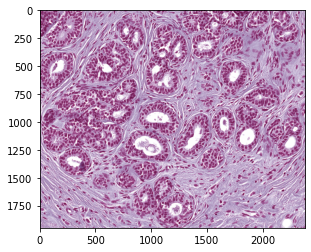

In [26]:
STAIN_NORM_TARGET_IMAGE = 'target.png'  # define stain normalization target image. 
normalizer = VahadaneStainNormalizer(target_path=STAIN_NORM_TARGET_IMAGE)



image = normalizer.process(image)

plt.imshow(image)

In [27]:
tissue_detector = ColorMergedSuperpixelExtractor(
            superpixel_size=500,
            compactness=20,
            blur_kernel_size=1,
            threshold=0.05,
            downsampling_factor=4
        )

        # b define feature extractor: Extract patches of 144x144 pixels all over 
        # the tissue regions. Each patch is resized to 224 to match ResNet input size.
tissue_feature_extractor = DeepFeatureExtractor(
            architecture='resnet34',
            patch_size=44,
            resize_size=224
        )

        # c define RAG builder. Append normalized centroid to the node features. 
rag_graph_builder = RAGGraphBuilder(add_loc_feats=True)

In [28]:
superpixels, _ = tissue_detector.process(image)
features = tissue_feature_extractor.process(image, superpixels)
graph = rag_graph_builder.process(superpixels, features)

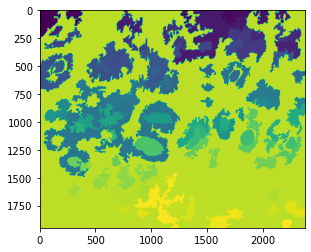

In [29]:
plt.imshow(superpixels)

In [32]:
print(len(np.unique(superpixels)))

100


In [34]:
graph 

DGLGraph(num_nodes=100, num_edges=328,
         ndata_schemes={'centroid': Scheme(shape=(2,), dtype=torch.float32), 'feat': Scheme(shape=(514,), dtype=torch.float32)}
         edata_schemes={})

In [36]:
print(features.shape)

torch.Size([100, 512])
